## Song Recommender Prototype
The dataset contains
- 1,019,318 unique users
- 384,546 unique MSD songs
- 48,373,586 user-song-playcount triplets

## 1. Setup

In [ ]:
!pip install --quiet cornac==1.6.1

In [ ]:
!git clone https://github.com/srendle/libfm.git
!make all -C libfm

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm

import cornac
from cornac.data import Reader
from cornac.eval_methods import BaseMethod, RatioSplit
from cornac.models import BPR, WMF

%load_ext autoreload
%autoreload 2
%matplotlib inline
%tensorflow_version 1.x
import tensorflow as tf

print(f"Cornac version: {cornac.__version__}")
print(f"Tensorflow version: {tf.__version__}")

MIN_PLAYCOUNT = 10
MIN_RATING = 50
TEST_RATIO = 0.33
SEED = 2020
VERBOSE = False
PLAY_COUNT_DATA_PATH = "gdrive/My Drive/Data/train_triplets.txt"
TRAIN_DATA_PATH = "gdrive/My Drive/Data/triplets_train.csv"
TEST_DATA_PATH = "gdrive/My Drive/Data/triplets_test.csv"
MODEL_DIR="gdrive/My Drive/Models/"

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


TensorFlow 1.x selected.
Cornac version: 1.6.1
Tensorflow version: 1.15.2


## 2. Data Exploration

In [ ]:
data = pd.read_csv(PLAY_COUNT_DATA_PATH, sep="\t", header=None)
data.columns = ["user_id", "song_id", "play_count"]

In [ ]:
data.head()

,user_id,song_id,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


#### Data Sparsity

In [ ]:
def display_sparsity(data):
    n_users = data.user_id.nunique()
    n_songs = data.song_id.nunique()
    n_playcounts = len(data)
    playcount_matrix_size = n_users * n_songs
    sparsity = 1 - n_playcounts / playcount_matrix_size

    print(f"Number of unique users: {n_users}")
    print(f"Number of unique songs: {n_songs}")
    print(f"Number of available playcounts: {n_playcounts}")
    print(f"Number of all possible playcounts: {playcount_matrix_size}")
    print("-" * 40)
    print(f"SPARSITY: {sparsity * 100.0:.5f}%")

In [ ]:
display_sparsity(data)

Number of unique users: 1019318
Number of unique songs: 384546
Number of available playcounts: 48373586
Number of all possible playcounts: 391974659628
----------------------------------------
SPARSITY: 99.98766%


#### Top 10 songs by number of users who have played it

In [ ]:
song_play_num_users = data.groupby("song_id")["user_id"].nunique().sort_values(ascending=False)
song_play_num_users.head(10)

song_id
SOFRQTD12A81C233C0    110479
SOAUWYT12A81C206F1     90476
SOAXGDH12A8C13F8A1     90444
SOBONKR12A58A7A7E0     84000
SOSXLTC12AF72A7F54     80656
SONYKOW12AB01849C9     78353
SOEGIYH12A6D4FC0E3     69487
SOLFXKT12AB017E3E0     64229
SODJWHY12A8C142CCE     63809
SOFLJQZ12A6D4FADA6     58610
Name: user_id, dtype: int64

#### Bottom 10 songs by number of users who have played it

In [ ]:
song_play_num_users.tail(10)

song_id
SONJAWX12A8C13E25B    1
SOKRIGC12A8C1372F1    1
SOPKNIR12A8C138662    1
SORKHCW12A8C13D894    1
SOKRHUB12AB017E7FA    1
SOHEVJV12AC468C3FF    1
SOZCCGY12A8C12FF83    1
SOEPLCT12AB018AF1D    1
SOHEVIS12AB0186DF6    1
SORLFZJ12A8C13341C    1
Name: user_id, dtype: int64

#### Top 10 users with most number of songs

In [ ]:
user_num_songs = data.groupby("user_id")["song_id"].nunique().sort_values(ascending=False)
user_num_songs.head(10)

user_id
ec6dfcf19485cb011e0b22637075037aae34cf26    4400
8cb51abc6bf8ea29341cb070fe1e1af5e4c3ffcc    1651
fef771ab021c200187a419f5e55311390f850a50    1614
5a3417a1955d9136413e0d293cd36497f5e00238    1604
c1255748c06ee3f6440c51c439446886c7807095    1566
4e73d9e058d2b1f2dba9c1fe4a8f416f9f58364f    1544
cbc7bddbe3b2f59fdbe031b3c8d0db4175d361e6    1536
96f7b4f800cafef33eae71a6bc44f7139f63cd7a    1491
119b7c88d58d0c6eb051365c103da5caf817bea6    1451
b7c24f770be6b802805ac0e2106624a517643c17    1446
Name: song_id, dtype: int64

#### Bottom 10 users with least number of songs
A user has at least listened to 10 songs.

In [ ]:
user_num_songs.tail(10)

user_id
2fd4c99cdc1232e9012299c6e41cb4a9f109a6a9    10
6b6ad4921f7510f48199c44c3f25e9045942373f    10
c531dc896216b11865071bd5f07d408e678c24da    10
c531c61652640db5e3d51c670c1df9cdb659698d    10
c52fedd2d9b96ccf22d3ff8775a82ccb62ad4fbe    10
c52fd9d20260585850f260fed445b633df9b3b71    10
1d477e518edfb3ebc6e56951e55570af25daffe3    10
6b6e2a832c28b6e09ac1b02f277c6cd821418020    10
2fd3dba782fe0b3ba2248e3b1153cdae97dcebc5    10
a546a96e6e0f12423bc27c01b2f43446ff0ca012    10
Name: song_id, dtype: int64

#### Data Statistics

In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
data.describe()

,play_count
count,48373586.000
mean,2.867
std,6.438
min,1.000
25%,1.000
50%,1.000
75%,3.000
max,9667.000


#### Power Law Distribution

In [ ]:
sample_size = 5000
seed = 2020
sample_df = song_play_num_users.sample(n=sample_size, random_state=seed)
sample_df = sample_df.sort_values(ascending=False)

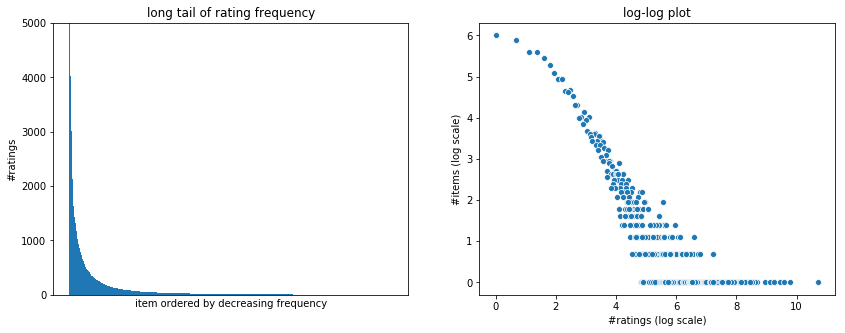

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

axes[0].bar(x=sample_df.index, height=sample_df.values, width=1.0, align="edge")
axes[0].set_xticks([])
axes[0].set(title="long tail of rating frequency", 
            xlabel="item ordered by decreasing frequency", 
            ylabel="#ratings")
axes[0].set_ylim([0, 5000])

count = sample_df.value_counts()
sns.scatterplot(x=np.log(count.index), y=np.log(count.values), ax=axes[1])
axes[1].set(title="log-log plot", xlabel="#ratings (log scale)", ylabel="#items (log scale)");

## 3. Data Processing

#### Filter out ratings with playcount < 10
Users might accidentally play a song. By removing ratings with less than 5 play counts, we try to remove this noise.

In [ ]:
filtered_df = data[data['play_count'] >= MIN_PLAYCOUNT]

#### Filter out songs with less than 50 ratings
It's hard to infer the general likeability of a song if there are too few ratings.

In [ ]:
grouped = filtered_df.groupby('song_id')
filtered_df = grouped.filter(lambda x: x["user_id"].nunique() >= MIN_RATING)

In [ ]:
filtered_df.head(5)

,user_id,song_id,play_count
164,969cc6fb74e076a68e36a04409cb9d3765757508,SONZWDK12A6701F62B,10
174,969cc6fb74e076a68e36a04409cb9d3765757508,SOXHIDK12A58A7CFB3,10
185,4bd88bfb25263a75bbdd467e74018f4ae570e5df,SOEPZQS12A8C1436C7,13
197,4bd88bfb25263a75bbdd467e74018f4ae570e5df,SOWPAXV12A67ADA046,18
198,4bd88bfb25263a75bbdd467e74018f4ae570e5df,SOXGQEM12AB0181D35,12


In [ ]:
filtered_df.describe()

,play_count
count,1549423.000
mean,20.412
std,22.521
min,10.000
25%,11.000
50%,15.000
75%,22.000
max,9667.000


In [ ]:
display_sparsity(filtered_df)

Number of unique users: 428878
Number of unique songs: 8356
Number of available playcounts: 1549423
Number of all possible playcounts: 3583704568
----------------------------------------
SPARSITY: 99.95676%


#### Train-Test Split

In [ ]:
train, test = train_test_split(filtered_df, test_size=TEST_RATIO, shuffle=True, random_state=SEED)

In [ ]:
# test_df = pd.DataFrame()
# train_df = pd.DataFrame()

# N = users.shape[0]
# for i in tqdm(range(N)): # progress bar
#     user_subset = data[data['user_id'] == users[i]]
#     # get the total number of ratings for this user
#     num_of_rows = user_subset.shape[0]
#     # calculate cutoff point based on test ratio
#     cutoff = int(round(num_of_rows * TEST_RATIO))

#     test_df = test_df.append(user_subset[:cutoff])
#     train_df = train_df.append(user_subset[cutoff:])

In [ ]:
train_df = pd.DataFrame(train, columns=["user_id", "song_id", "play_count"])
test_df = pd.DataFrame(test, columns=["user_id", "song_id", "play_count"])

#### Data Statistics

In [ ]:
display_sparsity(train_df)

Number of unique users: 367774
Number of unique songs: 8356
Number of available playcounts: 1038113
Number of all possible playcounts: 3073119544
----------------------------------------
SPARSITY: 99.96622%


In [ ]:
display_sparsity(test_df)

Number of unique users: 259968
Number of unique songs: 8356
Number of available playcounts: 511310
Number of all possible playcounts: 2172292608
----------------------------------------
SPARSITY: 99.97646%


#### Save to CSV files

In [ ]:
train_df.to_csv(TRAIN_DATA_PATH, sep='\t', index = False)
test_df.to_csv(TEST_DATA_PATH, sep='\t', index = False)

## 4. Base Model

#### Read CSV files

In [ ]:
reader = Reader()
train_data = reader.read(TRAIN_DATA_PATH, sep="\t", skip_lines=1)
test_data = reader.read(TEST_DATA_PATH, sep="\t", skip_lines=1)

#### Define Evaluation Metrics and Method

In [ ]:
K = 20
eval_metrics = [ 
  cornac.metrics.AUC(),
  cornac.metrics.Precision(k=K),
  cornac.metrics.Recall(k=K),
  cornac.metrics.NDCG(k=K),
]

In [ ]:
base_method = BaseMethod.from_splits(train_data, test_data, exclude_unknowns=True, seed=SEED, verbose=True)

rating_threshold = 1.0
exclude_unknowns = True
---
Training data:
Number of users = 367774
Number of items = 8356
Number of ratings = 1038113
Max rating = 9667.0
Min rating = 10.0
Global mean = 20.4
---
Test data:
Number of users = 198864
Number of items = 8356
Number of ratings = 435142
Number of unknown users = 0
Number of unknown items = 0
---
Total users = 367774
Total items = 8356


#### Train Base Models

In [ ]:
bpr = BPR(k=K, max_iter=50, learning_rate=0.01, lambda_reg=0.001, 
          verbose=True, seed=SEED, name=f"song_BPR(K={K})")
wmf = WMF(k=K, max_iter=50, a=1.0, b=0.01, learning_rate=0.001, lambda_u=0.01, lambda_v=0.01,
          verbose=True, seed=SEED, name=f"song_WMF(K={K})")

In [ ]:
cornac.Experiment(eval_method=base_method, models=[wmf, bpr], metrics=eval_metrics, save_dir=MODEL_DIR).run()


[song_WMF(K=20)] Training started!



Learning completed!

[song_WMF(K=20)] Evaluation started!



song_WMF(K=20) model is saved to gdrive/My Drive/Models/song_WMF(K=20)/2020-07-14_19-35-49-420011.pkl

[song_BPR(K=20)] Training started!



Optimization finished!

[song_BPR(K=20)] Evaluation started!



song_BPR(K=20) model is saved to gdrive/My Drive/Models/song_BPR(K=20)/2020-07-14_19-42-31-288065.pkl

TEST:
...
               |    AUC | NDCG@20 | Precision@20 | Recall@20 | Train (s) | Test (s)
-------------- + ------ + ------- + ------------ + --------- + --------- + --------
song_WMF(K=20) | 0.6128 |  0.0140 |       0.0035 |    0.0292 | 2974.1929 | 409.7904
song_BPR(K=20) | 0.7627 |  0.0570 |       0.0107 |    0.1051 |   29.6179 | 372.1238



## 5. Hyperparameter Tuning